In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import plot_style

data_dir = '../figure5/psycho_data'
data = np.load(data_dir + '/p_curves.npy', allow_pickle=True)
reliabilities = np.load(data_dir + '/reliabilities.npy', allow_pickle=True)
good_p_curves = data[reliabilities > 0.73]

In [4]:
from scipy.optimize import curve_fit
def logistic(x, a, b, c):
    return c / (1 + np.exp(-a * (x - b)))

In [5]:
# fit a logistic curve to all data
cue_count = np.arange(good_p_curves.shape[1])
popt, _ = curve_fit(logistic, np.tile(cue_count, good_p_curves.shape[0]), good_p_curves.flatten(), method='trf')

In [6]:
# fit a linear curve
def linear(x, m, c):
    return m * x + c

popt_linear, _ = curve_fit(linear, np.tile(cue_count, good_p_curves.shape[0]), good_p_curves.flatten())

In [7]:
# compute AIC and BIC for each curve, assuming normally distributed errors
def log_likelihood(y, mu, sigma):
    n = len(y)
    RSS = np.sum((y - mu) ** 2)
    return -0.5 * n * np.log(2 * np.pi * sigma ** 2) - 0.5 * RSS / sigma ** 2

def AIC(y, mu, sigma, k):
    return 2 * k - 2 * log_likelihood(y, mu, sigma)

def BIC(y, mu, sigma, k):
    return np.log(len(y)) * k - 2 * log_likelihood(y, mu, sigma)

logistic_mu = logistic(np.tile(cue_count, good_p_curves.shape[0]), *popt)
logistic_rss = good_p_curves.flatten() - logistic_mu
logistic_sigma = np.std(logistic_rss)
logistic_AIC = AIC(good_p_curves.flatten(), logistic_mu, logistic_sigma, k=len(popt) + 1)
logistic_BIC = BIC(good_p_curves.flatten(), logistic_mu, logistic_sigma, k=len(popt) + 1)

linear_mu = linear(np.tile(cue_count, good_p_curves.shape[0]), *popt_linear)
linear_rss = good_p_curves.flatten() - linear_mu
linear_sigma = np.std(linear_rss)
linear_AIC = AIC(good_p_curves.flatten(), linear_mu, linear_sigma, k=len(popt_linear) + 1)
linear_BIC = BIC(good_p_curves.flatten(), linear_mu, linear_sigma, k=len(popt_linear) + 1)

In [8]:
print(f'Logistic AIC: {logistic_AIC}, BIC: {logistic_BIC}, RSS: {np.sum(logistic_rss ** 2)}')
print(f'Linear AIC: {linear_AIC}, BIC: {linear_BIC}, RSS: {np.sum(linear_rss ** 2)}')

Logistic AIC: -1147.604796102634, BIC: -1127.2779617582119, RSS: 26.383400601541105
Linear AIC: -987.5981466145647, BIC: -972.353020856248, RSS: 30.231217845471562


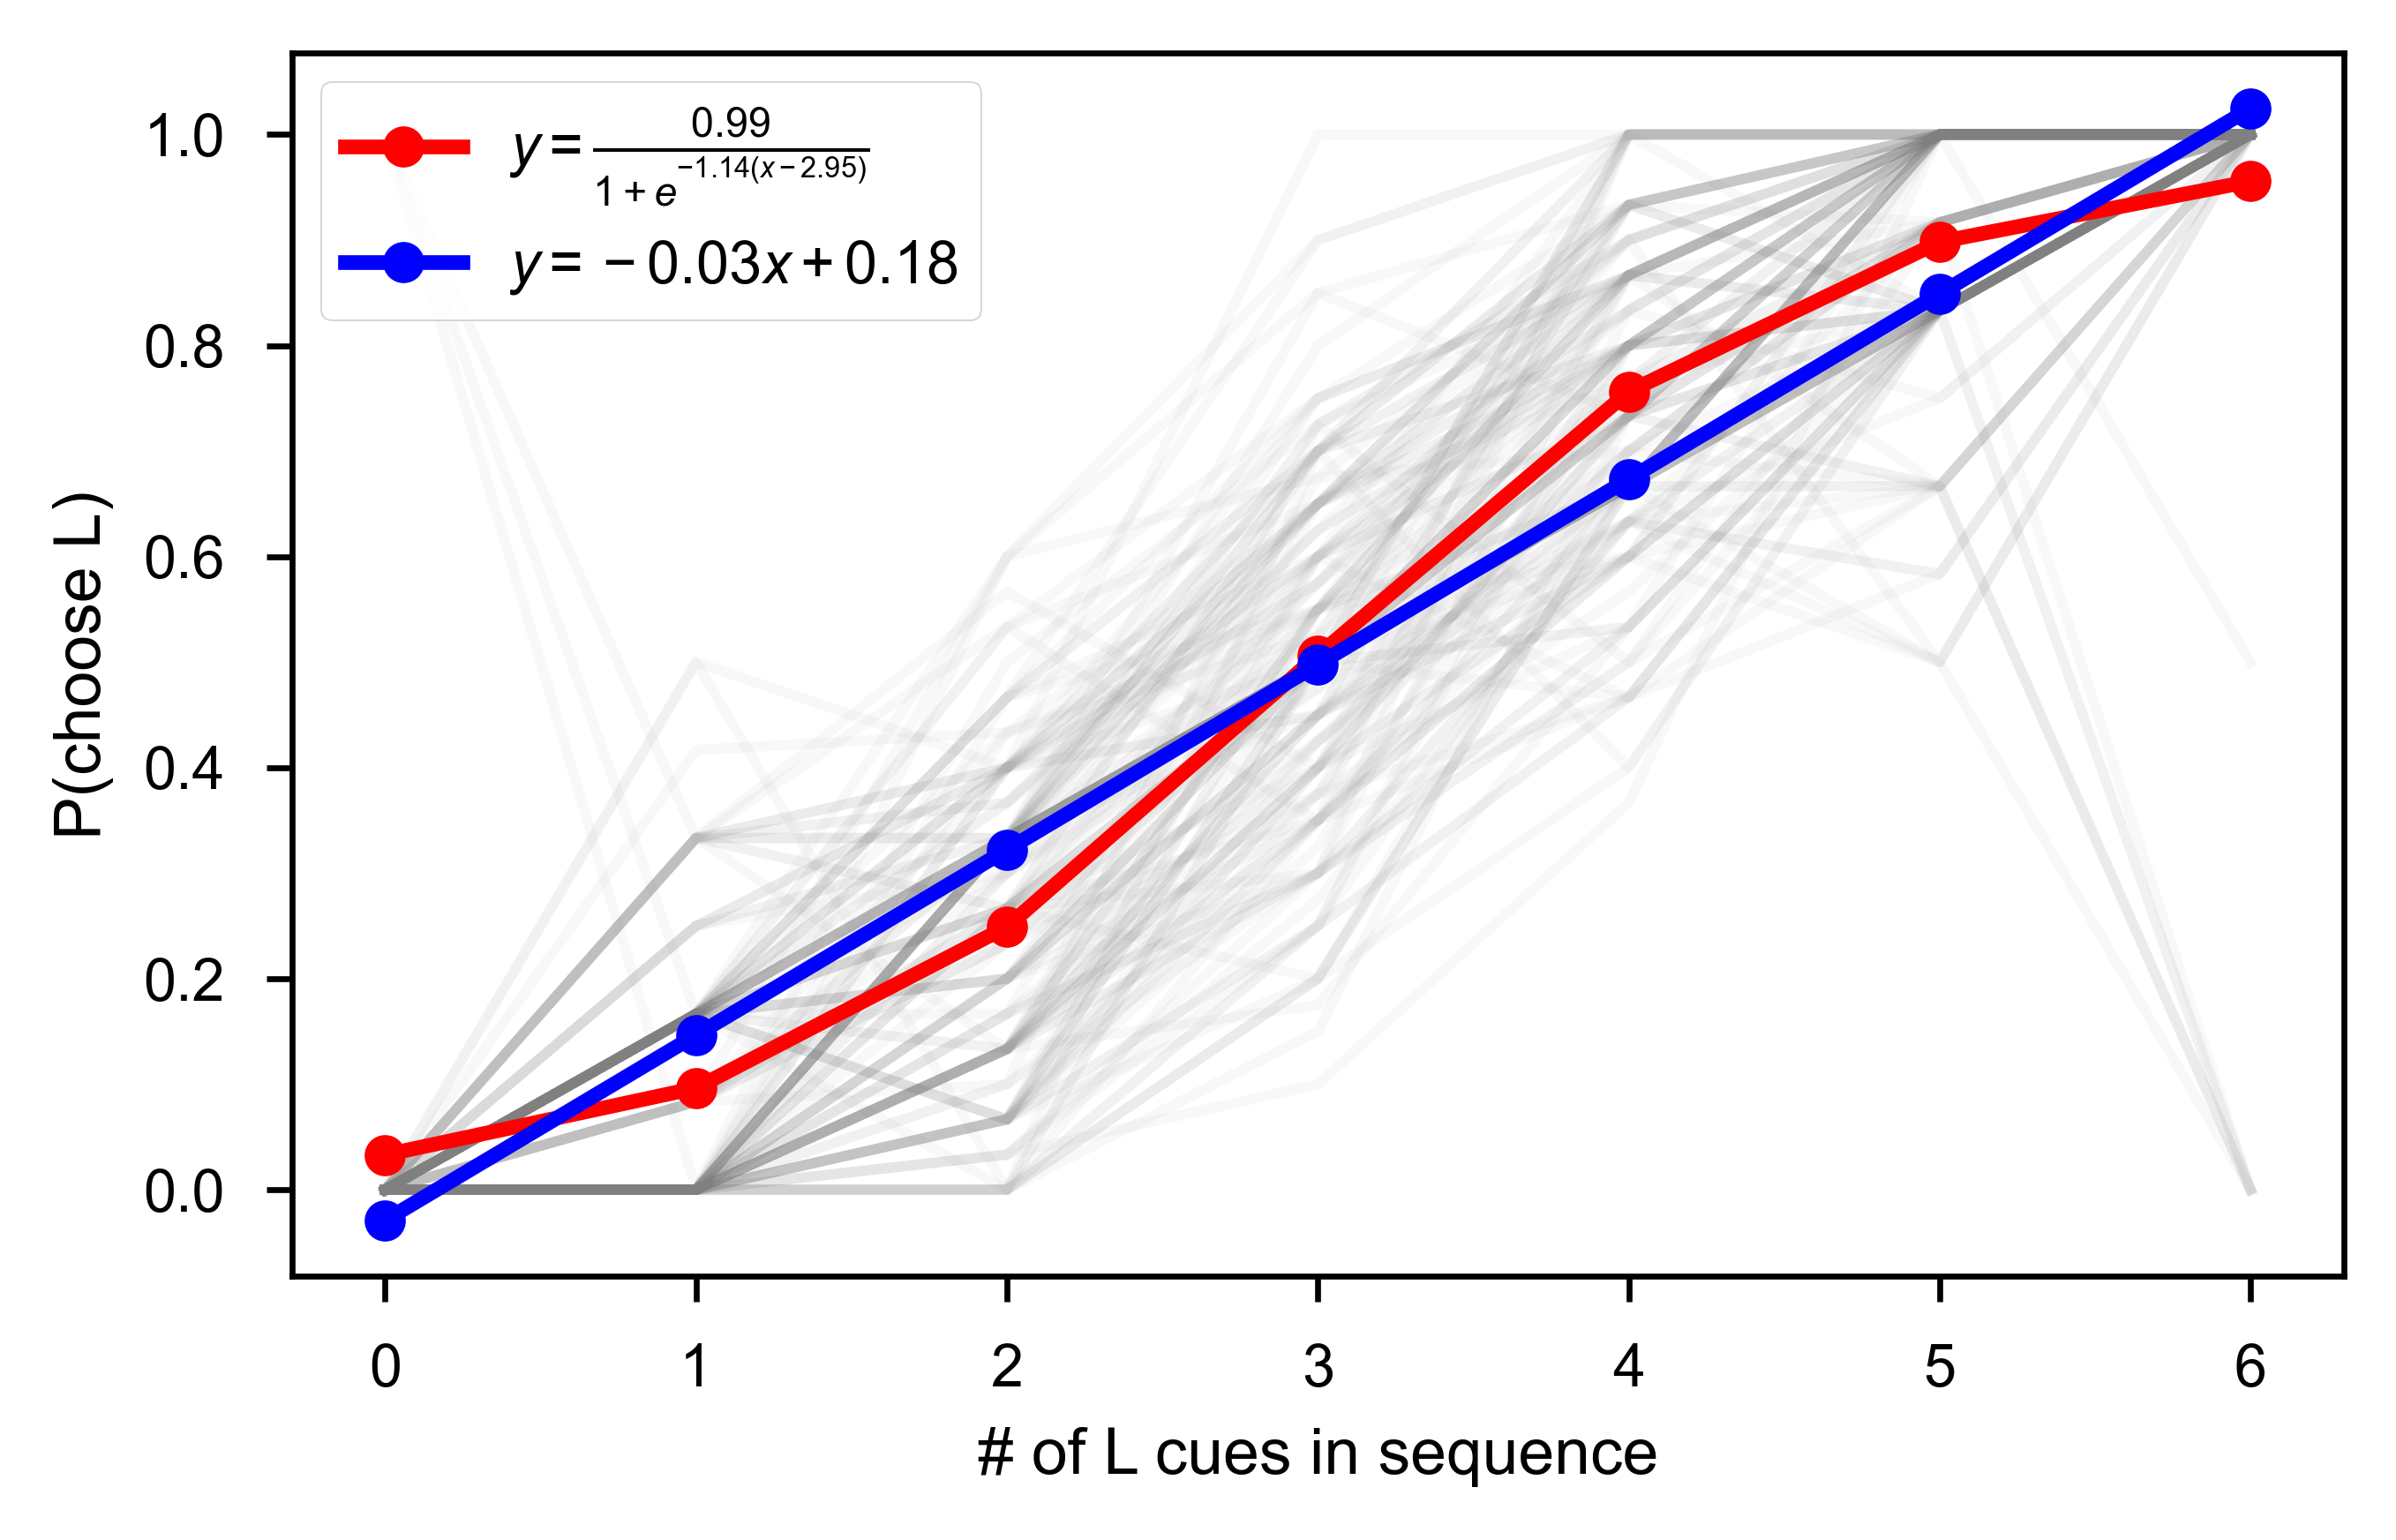

In [25]:
# plot good_p_curves and logistic fit
plt.figure(figsize=(5, 3))
plt.plot(cue_count, good_p_curves.T, color='gray', alpha=0.05)
log_label = fr'$y = \frac{{{popt[2]:.2f}}}{{1 + e^{{-{popt[0]:.2f}(x - {popt[1]:.2f})}}}}$'
plt.plot(cue_count, logistic(cue_count, *popt), '-o' ,color='red', linewidth=2, label=log_label)
lin_label = fr'$y = {popt_linear[1]:.2f}x + {popt_linear[0]:.2f}$'
plt.plot(cue_count, linear(cue_count, *popt_linear), '-o', color='blue', linewidth=2, label=lin_label)
plt.xlabel('# of L cues in sequence')
plt.ylabel('P(choose L)')
plt.legend()
plt.show()